In [55]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-06-10 09:04:10--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative50.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.10.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.10.165|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-06-10 09:04:10 ERROR 403: Forbidden.



In [21]:
!ls

GoogleNews-vectors-negative300.bin.gz  __notebook_source__.ipynb


In [5]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /usr/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to
[nltk_data]    |     /usr/share/nltk_data

[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to /usr/share/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to /usr/share/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks

True

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import Embedding, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


from bs4 import BeautifulSoup
import re,string,unicodedata

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models.keyedvectors import KeyedVectors

In [13]:
df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [14]:
df_fake['label'] = 1
df_true['label'] = 0

In [15]:
df = pd.concat([df_fake, df_true])

In [16]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [17]:
features, labels = df['text'].tolist(), df['label'].tolist()


In [19]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#remove html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)


#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def clean_data(feature_list):
    feature_list = list(map(lambda x: x.lower(), feature_list))
    feature_list = list(map(strip_html, feature_list))
    feature_list = list(map(decontracted, feature_list))
    feature_list = list(map(remove_between_square_brackets, feature_list))
    feature_list = list(map(remove_urls, feature_list))
    feature_list = list(map(remove_stopwords, feature_list))
    
    return feature_list

In [20]:
features = clean_data(features)


In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')


In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [22]:
#max length of each text 
MAX_SEQUENCE_LENGTH = 500

#only take 10000 words from all unique words(or only 10000 features max)
MAX_NUM_WORDS = 10000

#each word should be represented by 300 dimension
EMBEDDING_DIM = 300

#ratio of train/test will be 80/20
VALIDATION_SPLIT = 0.2

#path for glove embedding file
word2vec_txt_path = "GoogleNews-vectors-negative300.bin.gz"

In [23]:
x_train,x_test,y_train,y_test = train_test_split(features, labels, stratify=labels, random_state = 42, test_size=VALIDATION_SPLIT, shuffle=True)

In [24]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)

In [25]:
def create_tokens(tokenizer, data, max_seq_len):
    tokenized_data = tokenizer.texts_to_sequences(data)
    padded_tokenized_data = pad_sequences(tokenized_data, maxlen=max_seq_len)
    return padded_tokenized_data

In [26]:
X_train = create_tokens(tokenizer, x_train, MAX_SEQUENCE_LENGTH)
X_test = create_tokens(tokenizer, x_test, MAX_SEQUENCE_LENGTH)

In [27]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [42]:
def get_embeddings(path):
    # model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300', binary=True, limit=500000)
    wv_from_bin = KeyedVectors.load_word2vec_format(path, binary=True, limit=MAX_NUM_WORDS) 
    #extracting word vectors from google news vector
    embeddings_index = {}
    for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
        coefs = np.asarray(vector, dtype='float32')
        embeddings_index[word] = coefs

    return embeddings_index

In [57]:
embeddings_index = get_embeddings(word2vec_txt_path)

In [58]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [59]:
del embeddings_index

In [60]:
def create_model(embed_matrix, max_num_words, embed_dim, max_seq_len):
    model = Sequential()
    model.add(Embedding(max_num_words, output_dim=embed_dim, weights=[embed_matrix], input_length=max_seq_len, trainable=False))  

    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid')) #here activation function is sigmoid because we want only one output 0/1
    
    return model

In [61]:
#creating model instance
model = create_model(embedding_matrix, MAX_NUM_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

#compile mode with optimizer = adam, loss = binary_crossentropy, metrics = accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 10

#setting callback function for reducing learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

#setting callback functiob for sarly stopping if loss is not decreasing
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


history = model.fit(X_train, 
                    y_train, 
                    batch_size = batch_size , 
                    validation_data = (X_test,y_test) ,
                    epochs = epochs, 
                    shuffle=True,
                    callbacks = [learning_rate_reduction, es])

Epoch 1/10
281/281 [==============================] - 11s 38ms/step - loss: 0.1974 - accuracy: 0.9153 - val_loss: 0.0141 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 2/10
281/281 [==============================] - 10s 35ms/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.0155 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 3/10
281/281 [==============================] - 10s 35ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 4/10
281/281 [==============================] - 10s 35ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 5/10
281/281 [==============================] - 10s 35ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0067 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 6/10
281/281 [==============================] - 10s 35ms/step - loss: 7.3417e-04 - accuracy: 0.9998 - val_loss: 0.0072 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 7/10
280/281 [============================>.] - 

In [62]:
accr_train = model.evaluate(X_train,y_train)
print('Accuracy Train: {}'.format(accr_train[1]*100))
accr_test = model.evaluate(X_test,y_test)
print('Accuracy Test: {}'.format(accr_test[1]*100))

1123/1123 [==============================] - 8s 7ms/step - loss: 1.7444e-04 - accuracy: 1.0000
Accuracy Train: 100.0
281/281 [==============================] - 2s 7ms/step - loss: 0.0068 - accuracy: 0.9989
Accuracy Test: 99.88864064216614


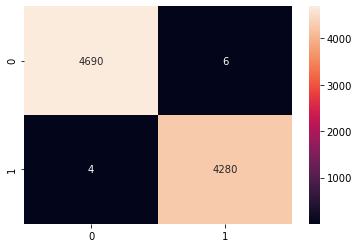

In [64]:
pred = model.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

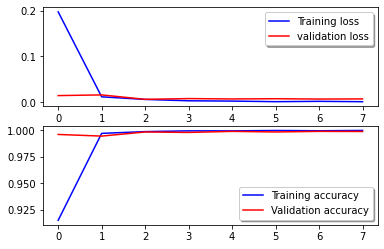

In [65]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)